Turning point on row: 912 which is date: 2013-07-01 00:00:00 at 0.0005871746143341998 TH/J


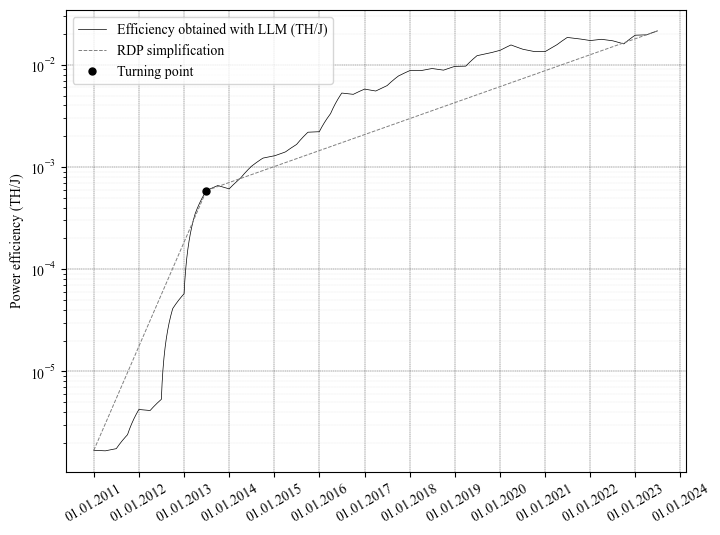

In [30]:
from __future__ import annotations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib as mpl
from datetime import timedelta

EXTRA_STUFF_ENABLED = False


# Load the CSV file
df_data = pd.read_csv('monthly_efficiency.csv', parse_dates=['date'])

# Filter the data to include only dates after '2011-02-01'
# df_data = df_data[df_data['date'] > '2011-02-01']

# Calculate the quarterly average of the efficiency
df_data['quarter'] = (df_data['date'] - timedelta(days=45)).dt.to_period('Q')
quarterly_data = df_data.groupby('quarter')['efficiency'].mean().reset_index()
quarterly_data['quarter'] = quarterly_data['quarter'].dt.to_timestamp()

# Set the 'quarter' column as the index
quarterly_data.set_index('quarter', inplace=True)

# Resample the data to daily frequency, creating NaN values for new days
daily_data = quarterly_data.resample('D').asfreq()

# Interpolate the missing data points
daily_data_interpolated = daily_data.interpolate(method='linear')

# Extract the relevant columns
df_efficiency = daily_data_interpolated['efficiency'].dropna()
df_date = df_efficiency.index

# Ensure the lengths match
count_row_date = df_date.shape[0]
count_row_efficiency = df_efficiency.shape[0]
if count_row_date != count_row_efficiency:
    df_efficiency = df_efficiency.iloc[:-(count_row_efficiency - count_row_date)]

# Log-transform the efficiency data
df_efficiency_log = np.log10(df_efficiency)

def point_line_distance(point, start, end):
    if start == end:
        return sqrt((point[0] - start[0]) ** 2 + (point[1] - start[1]) ** 2)
    else:
        n = abs((end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1]))
        d = sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        return n / d

def ramer_douglas_peucker(points, epsilon):
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax >= epsilon:
        results = ramer_douglas_peucker(points[:index+1], epsilon)[:-1] + ramer_douglas_peucker(points[index:], epsilon)
    else:
        results = [points[0], points[-1]]
    return results

def angle(dir):
    dir2 = dir[1:]
    dir1 = dir[:-1]
    return np.arccos((dir1*dir2).sum(axis=1)/(np.sqrt((dir1**2).sum(axis=1)*(dir2**2).sum(axis=1))))

# Ramer–Douglas–Peucker algorithm
tolerance = 1.3
min_angle = 0.0
number_days_list = list(range(count_row_date))
points = list(zip(number_days_list, df_efficiency_log))
simplified = np.array(ramer_douglas_peucker(points, tolerance))
directions = np.diff(simplified, axis=0)
theta = angle(directions)
idx = np.where(theta > min_angle)[0] + 1

# Prepare max efficiency data for step plot
df_max_efficiency = df_data.set_index('date')['max_efficiency'].dropna()
df_max_efficiency = df_max_efficiency.reindex(df_date, method='ffill')

# Plotting the figure with turning point
plt.rcParams["font.family"] = "Times New Roman"
x = df_date
y_efficiency = [10 ** y for y in df_efficiency_log]
y_max_efficiency = df_max_efficiency
simpli_x, simpli_y = simplified.T
turn_point_row = int(simpli_x[1])
simpli_x = [df_date[int(simpli_x[d])] for d in range(len(simpli_x))]
simpli_y = [10 ** y for y in simpli_y]

print('Turning point on row:', turn_point_row, 'which is date:', simpli_x[1], 'at', simpli_y[1], 'TH/J')

# Create a figure with a custom layout
if EXTRA_STUFF_ENABLED:
    fig = plt.figure(figsize=(15, 6))
else:
    fig = plt.figure(figsize=(8, 6))
if EXTRA_STUFF_ENABLED:
    gs = fig.add_gridspec(1, 2, width_ratios=[7, 3])
else:
    gs = fig.add_gridspec(1, 1)

# Main plot (a)
ax_main = fig.add_subplot(gs[0])
ax_main.plot(x, y_efficiency, 'k-', linewidth=0.5, label='Efficiency obtained with LLM (TH/J)')
if EXTRA_STUFF_ENABLED:
    ax_main.step(x, y_max_efficiency, 'b-', linewidth=0.5, where='post', label='Max Efficiency achievable (TH/J)')
else:
    ax_main.plot(simpli_x, simpli_y, c='0.5', linewidth=0.7, linestyle='dashed', label='RDP simplification')

# Highlight the transition zone
if EXTRA_STUFF_ENABLED:
    turning_point_date = simpli_x[int(idx[0])]
    transition_start = turning_point_date - pd.Timedelta(days=182.5)
    transition_end = turning_point_date + pd.Timedelta(days=182.5)
    transition_zone = ax_main.axvspan(transition_start, transition_end, color='gray', alpha=0.3, label='Transition zone')

# Plot the turning point
ax_main.plot(turning_point_date, simpli_y[int(idx[0])], 'ko', markersize=5, label='Turning point')

# Plot the fitted line segments
# ax_main.plot(simpli_x[:int(idx[0])+1], simpli_y[:int(idx[0])+1], 'k-', linewidth=1.5, label='Pre-turning point')

if EXTRA_STUFF_ENABLED:
    ax_main.plot(simpli_x[int(idx[0]):], simpli_y[int(idx[0]):], 'orange', linewidth=1.5, label="Koomey's post-2000 law")

# Plot cost_per_coin
cost_per_coin = pd.read_csv('cost_per_coin.csv', parse_dates=['date'],index_col='date')
# ax_main.plot(cost_per_coin.index, cost_per_coin['cost_per_coin']/1e6, 'r-', linewidth=0.5, label='Modelled mining costs (Million USD)')

# Formatting the x-axis
ax_main.xaxis.set_major_locator(mpl.dates.YearLocator(base=1))
ax_main.xaxis.set_major_formatter(mpl.dates.DateFormatter("01.01.%Y"))
ax_main.tick_params(axis='x', rotation=30)

# Set y-axis to log scale
ax_main.set_yscale('log')
ax_main.set_ylabel('Power efficiency (TH/J)')
ax_main.legend(loc='best')

# Grid settings
ax_main.xaxis.grid(True, 'minor', linestyle='--', linewidth=0.1)
ax_main.yaxis.grid(True, 'minor', linestyle='--', linewidth=0.1)
ax_main.xaxis.grid(True, 'major', linestyle='--', linewidth=0.25, color='k')
ax_main.yaxis.grid(True, 'major', linestyle='--', linewidth=0.25, color='k')

# Add "a)" text
if EXTRA_STUFF_ENABLED:
    ax_main.text(0.01, 0.99, 'a)', transform=ax_main.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


# Inset plot (b)
if EXTRA_STUFF_ENABLED:
    df_data2 = pd.read_excel('Bitcoin Paper Datasheet.xlsx', engine='openpyxl', sheet_name='Turning Point')
    df_hashrate, df_date2 = df_data2['Hashrate (TH/s)'].dropna(), df_data2['Date'].dropna()
    count_row_date, count_row_hashrate = df_date2.shape[0], df_hashrate.shape[0]
    if count_row_date != count_row_hashrate: df_hashrate = df_hashrate.iloc[:-(count_row_hashrate - count_row_date)]

    ax_inset = fig.add_subplot(gs[1])
    ax_inset.plot(df_date2, df_hashrate, 'k-', linewidth=0.3, label='Hardware evolution')
    ax_inset.set_ylim(10**(int(np.log10(np.min(df_hashrate))) + 2), 10**(int(np.log10(np.max(df_hashrate))) + 1))
    ax_inset.set_xlim(min(df_date2), max(df_date2))
    ax_inset.tick_params(axis='x', rotation=30)
    ax_inset.xaxis.set_major_locator(mpl.dates.YearLocator(base=2))
    ax_inset.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
    ax_inset.plot(simpli_x[int(idx)], df_hashrate[turn_point_row], 'ko', markersize=3)
    ax_inset.set_yscale('log')
    ax_inset.set_ylabel('Hashrate (TH/s)')
    ax_inset.xaxis.grid(True, 'minor', linestyle='--', linewidth=0.1)
    ax_inset.yaxis.grid(True, 'minor', linestyle='--', linewidth=0.1)
    ax_inset.xaxis.grid(True, 'major', linestyle='--', linewidth=0.25, color='k')
    ax_inset.yaxis.grid(True, 'major', linestyle='--', linewidth=0.25, color='k')

    # Add "b)" text
    ax_inset.text(0.01, 0.99, 'b)', transform=ax_inset.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

if EXTRA_STUFF_ENABLED:
    plt.savefig('turning_point_no_cost.pdf', format='pdf')
else:
    plt.savefig('turning_point_alone.pdf', format='pdf')
plt.show()

df_data3 = pd.read_excel('Bitcoin Paper Datasheet.xlsx', engine='openpyxl', sheet_name='Co-Integration')
df_price = 10**df_data3['y1 = LOG BTC']

In [31]:
df_price

0           0.060000
1           0.060000
2           0.060000
3           0.060000
4           0.060000
            ...     
4494    22676.552721
4495    22777.625018
4496    22720.416009
4497    22934.431643
4498    22906.873052
Name: y1 = LOG BTC, Length: 4499, dtype: float64

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Split the data into two parts using the turning point row
efficiency_pre_turn = df_efficiency_log[:turn_point_row]
efficiency_post_turn = df_efficiency_log[turn_point_row:]

# Create the x values for the two parts
x_pre_turn = np.arange(len(efficiency_pre_turn)).reshape(-1, 1)
x_post_turn = np.arange(len(efficiency_post_turn)).reshape(-1, 1)

# Fit linear models to each part
model_pre_turn = LinearRegression().fit(x_pre_turn, efficiency_pre_turn)
model_post_turn = LinearRegression().fit(x_post_turn, efficiency_post_turn)

# Predict the efficiency values using the fitted models
efficiency_pre_turn_pred = model_pre_turn.predict(x_pre_turn)
efficiency_post_turn_pred = model_post_turn.predict(x_post_turn)

# Compute the R^2 values
r2_pre_turn = r2_score(efficiency_pre_turn, efficiency_pre_turn_pred)
r2_post_turn = r2_score(efficiency_post_turn, efficiency_post_turn_pred)

# Extract the coefficients for the exponential models
a1 = 10 ** model_pre_turn.intercept_
b1 = model_pre_turn.coef_[0]
a2 = 10 ** model_post_turn.intercept_
b2 = model_post_turn.coef_[0]

# Define the dates for the regimes
start_date_pre_turn = df_date[0]
end_date_pre_turn = df_date[turn_point_row - 1]
start_date_post_turn = df_date[turn_point_row]
end_date_post_turn = df_date[-1]

# Define the transition period
transition_start = turning_point_date - pd.Timedelta(days=182.5)
transition_end = turning_point_date + pd.Timedelta(days=182.5)

# Print the results in LaTeX format
print(f"For the first regime before the turning point, $\\mathrm{{R^2}}$ = {r2_pre_turn:.4f} from {start_date_pre_turn.strftime('%B %Y')} to {end_date_pre_turn.strftime('%B %Y')}, $\\mathrm{{eff_1(t) = {a1:.2e}\\times e^{{{b1:.2e} \times t}}}}$.")
print(f"For the second regime following Koomey's post-2000 law, $\\mathrm{{R^2}}$ = {r2_post_turn:.4f} from {start_date_post_turn.strftime('%B %Y')} to {end_date_post_turn.strftime('%B %Y')}, $\\mathrm{{eff_2(t) = {a2:.2e}\\times e^{{{b2:.2e} \times t}}}}$.")
print(f"The transition period is between {transition_start.strftime('%B %Y')} and {transition_end.strftime('%B %Y')}. The unit t is one day and starts from 0 in {start_date_pre_turn.strftime('%B %Y')}")

For the first regime before the turning point, $\mathrm{R^2}$ = 0.8807 from January 2011 to June 2013, $\mathrm{eff_1(t) = 4.75e-07\times e^{3.01e-03 	imes t}}$.
For the second regime following Koomey's post-2000 law, $\mathrm{R^2}$ = 0.8884 from July 2013 to July 2023, $\mathrm{eff_2(t) = 1.01e-03\times e^{4.26e-04 	imes t}}$.
The transition period is between December 2012 and December 2013. The unit t is one day and starts from 0 in January 2011


In [33]:
print("bias for the pre-turning point data: ", model_pre_turn.intercept_)
print("coefficient for the pre-turning point data: ", model_pre_turn.coef_)
print("bias for the post-turning point data: ", model_post_turn.intercept_)
print("coefficient for the post-turning point data: ", model_post_turn.coef_)

bias for the pre-turning point data:  -6.323199771947194
coefficient for the pre-turning point data:  [0.0030122]
bias for the post-turning point data:  -2.9940905371382667
coefficient for the post-turning point data:  [0.00042638]
